# Sushant EDA

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import json
import csv
import re
from dotenv import dotenv_values
from collections import OrderedDict

In [55]:
# OrderedDict containing key-value pairs of secret keys
config = dotenv_values("../.env")

In [57]:
CDC_APP_TOKEN = config['CDC_APP_TOKEN']

## Load the CDC Asthma Data

There are 80342 rows in the original database, but we can easily query 50000 of them using the API limit.

In [71]:
### QUERY PARAMETERS ###
limit = 50000 # number of records to return

In [72]:
# Use this cell for customized queries on the asthma dataset
url = f'https://chronicdata.cdc.gov/resource/us8e-ubyj.json?$limit={limit}'
headers = {
    "X-App-Token": CDC_APP_TOKEN,
}
 
response = requests.request("GET", url, headers=headers)
asthma_data = json.loads(response.content)
asthma_data = pd.json_normalize(asthma_data)
asthma_data.to_csv('asthma_data.csv')


In [81]:
# get remaining 30000 rows if desired
offset = 50000
url = f'https://chronicdata.cdc.gov/resource/us8e-ubyj.json?$limit={limit}&$offset={offset}'
headers = {
    "X-App-Token": CDC_APP_TOKEN,
}
 
response = requests.request("GET", url, headers=headers)
asthma_data_remaining = json.loads(response.content)
asthma_data_remaining = pd.json_normalize(asthma_data_remaining)

# merge the two asthma dataframes to form the entire dataset
asthma_data_full = pd.concat([asthma_data, asthma_data_remaining], axis=0)
asthma_data_full.to_csv('asthma_data_full.csv')

## Load in the PM2.5 Concentrations Data

This dataset contains 105,000,000 rows... so what do we want from it?

In [74]:
### QUERY PARAMETERS ###
limit = 50000 # number of records to return

In [75]:
url = f'https://data.cdc.gov/resource/fcqm-xrf4.json?$limit={limit}'
headers = {
    "X-App-Token": CDC_APP_TOKEN,
}
 
response = requests.request("GET", url, headers=headers)
pm_conc_data = json.loads(response.content)
pm_conc_data = pd.json_normalize(pm_conc_data)
pm_conc_data.to_csv('pm_conc_data.csv')

In [76]:
pm_conc_data

,year,date,statefips,countyfips,ctfips,latitude,longitude,ds_pm_pred,ds_pm_stdd
0,2014,12SEP2014,24,24003,24003706401,38.96064,-76.50283,4.7926,2.6723
1,2014,12SEP2014,24,24033,24033805000,38.9607,-76.98349,5.6251,2.906
2,2014,12SEP2014,24,24031,24031705602,38.96089,-77.09036,5.4994,2.9666
3,2014,12SEP2014,51,51059,51059480902,38.96091,-77.383,4.7111,2.6945
4,2014,12SEP2014,24,24033,24033805101,38.96111,-76.97331,5.5917,2.9533
...,...,...,...,...,...,...,...,...,...
49995,2014,13SEP2014,4,4013,4013071517,33.6011,-112.24661,4.0091,1.7374
49996,2014,13SEP2014,4,4013,4013060904,33.60151,-112.3109,4.0399,1.798
49997,2014,13SEP2014,6,6065,6065043270,33.60152,-117.25892,16.7586,8.7872
49998,2014,13SEP2014,4,4013,4013061041,33.60158,-112.32917,4.0543,1.8131


# EDA

## Asthma EDA

In [82]:
asthma = asthma_data_full

In [84]:
asthma.columns

Index(['yearstart', 'yearend', 'locationabbr', 'locationdesc', 'datasource',
       'topic', 'question', 'datavaluetype', 'datavalue', 'datavaluealt',
       'stratificationcategory1', 'stratification1', 'locationid', 'topicid',
       'questionid', 'datavaluetypeid', 'stratificationcategoryid1',
       'stratificationid1', 'datavaluefootnotesymbol', 'datavaluefootnote',
       'datavalueunit', 'lowconfidencelimit', 'highconfidencelimit'],
      dtype='object')

### Preprocessing: datavalue

In [104]:
asthma['datavalue'] = asthma['datavalue'].astype(float)
asthma['datavaluealt'] = asthma['datavaluealt'].astype(float)

In [116]:
# Just about half of the values are nan, and they seem to match up precisely
asthma[['datavalue', 'datavaluealt']].isna().value_counts()
# Since datavaluealt is the exact same as datavalue, we'll remove it below

datavalue  datavaluealt
True       True            40496
False      False           39846
Name: count, dtype: int64

### Dropping unnecessary columns

In [136]:
# Remove unnecessary columns
asthma_dropped = asthma.drop(['yearend', 'locationdesc', 'topic', 
'datasource', 'datavaluealt', 'stratificationcategory1', 'locationid', 'topicid', 'datavaluetypeid',
'stratificationid1', 'datavaluefootnotesymbol'], axis=1)
### NOTES ###
# stratificationid1 is a more concise version of stratification1, but the conventions
#    are weird so I dropped it

In [137]:
asthma_dropped

,yearstart,locationabbr,question,datavaluetype,datavalue,stratification1,questionid,stratificationcategoryid1,datavaluefootnote,datavalueunit,lowconfidencelimit,highconfidencelimit
0,2014,AR,Hospitalizations for asthma,Number,916.0,Male,AST3_1,GENDER,NaN,NaN,NaN,NaN
1,2018,CO,Hospitalizations for asthma,Number,2227.0,Overall,AST3_1,OVERALL,NaN,NaN,NaN,NaN
2,2018,DC,Hospitalizations for asthma,Number,708.0,Overall,AST3_1,OVERALL,NaN,NaN,NaN,NaN
3,2017,GA,Hospitalizations for asthma,Number,3520.0,Female,AST3_1,GENDER,NaN,NaN,NaN,NaN
4,2010,MI,Hospitalizations for asthma,Number,123.0,Hispanic,AST3_1,RACE,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
30337,2020,WY,Influenza vaccination among noninstitutionaliz...,Age-adjusted Prevalence,NaN,"Black, non-Hispanic",AST5_1,RACE,Sample size of denominator and/or age group fo...,%,NaN,NaN
30338,2020,WY,Pneumococcal vaccination among noninstitutiona...,Age-adjusted Prevalence,NaN,"Black, non-Hispanic",AST6_2,RACE,Sample size of denominator and/or age group fo...,%,NaN,NaN
30339,2020,WY,Influenza vaccination among noninstitutionaliz...,Crude Prevalence,68.9,Female,AST5_2,GENDER,NaN,%,57.6,78.4
30340,2020,WY,Pneumococcal vaccination among noninstitutiona...,Crude Prevalence,88.4,Female,AST6_2,GENDER,NaN,%,78.1,94.2


### Topical analysis

In [141]:
asthma_dropped.question.value_counts()

question
Asthma mortality rate                                                                      13497
Current asthma prevalence among adults aged >= 18 years                                     9570
Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma        9570
Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma        9570
Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma     9570
Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma     9570
Hospitalizations for asthma                                                                 7812
Emergency department visit rate for asthma                                                  7608
Asthma prevalence among women aged 18-44 years                                              3575
Name: count, dtype: int64

In [182]:
## Asthma mortality rate over time ##

def mortality_rate_over_time(states, stratificationcategoryid1, 
                            datavaluetype, overlay_states=False, 
                            stratification1=None):
    """
    Visualize the mortality rate of asthma over time.

    Parameters
    ----------
    states: list
        List of states (abbreviations) to visualize. Even a single state should be
        in the list.
    overlay_states: boolean
        Whether to overlay the lineplots of multiple states on top of each other.
        TODO: Implement this feature.
    stratificationcategoryid1: string
         'OVERALL' : Captures mortality rate of everyone in a given state 
                     irrespective of race or gender.
         'RACE' : Captures mortality rate on racial lines.
         'GENDER' : Captures mortality rate on gender lines.
    stratification1 (optional) : string
        If stratificationcategoryid1 == 'RACE':
            'Hispanic', 'White, non-Hispanic', 'Black, non-Hispanic',
            'Other, non-Hispanic', 'Multiracial, non-Hispanic',
            'Asian or Pacific Islander', 'American Indian or Alaska Native'
        If stratificationcategoryid1 == 'GENDER':
            'Male', 'Female'
    datavaluetype : string
        'Number' : FIXME 
        'Crude Rate' : FIXME
        'Age-adjusted Rate' : FIXME
        'Crude Prevalence' : FIXME
        'Age-adjusted Prevalence' : FIXME
    """
    data = asthma_dropped[asthma_dropped['question']=='Asthma mortality rate']
    data = data[data['locationabbr'] == states[0]]
    data = data[data['stratificationcategoryid1'] == stratificationcategoryid1]
    data = data[data['datavaluetype'] == datavaluetype]
    data.sort_values(by='yearstart', ascending=True)
    sns.lineplot(data=data[['yearstart', 'datavalue']], x='yearstart', y='datavalue').set(
        title = f'{datavaluetype} of Asthma Mortality in {states[0]} {stratificationcategoryid1}'
    )
    plt.ylabel(datavaluetype)
    

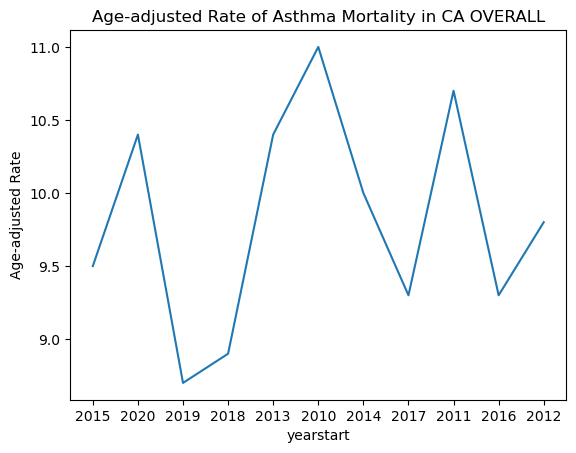

In [183]:
mortality_rate_over_time(states=['CA'], stratificationcategoryid1='OVERALL', datavaluetype='Age-adjusted Rate')

In [159]:
asthma_dropped['datavaluetype'].value_counts().index

Index(['Crude Prevalence', 'Age-adjusted Prevalence', 'Number', 'Crude Rate',
       'Age-adjusted Rate'],
      dtype='object', name='datavaluetype')